In [1]:
import sys
import random
import matplotlib.pyplot as plt
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
import functools
from tqdm import tqdm
from IPython.display import display
from transformer_lens.hook_points import HookPoint
from transformer_lens import (
    utils,
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)
import circuitsvis as cv
import os
from functools import partial

import itertools
# Saves computation time, since we don't need it for the contents of this notebook
t.set_grad_enabled(False)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

if not t.backends.mps.is_available():
    if not t.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = t.device("mps")

MAIN = __name__ == "__main__"

In [2]:
from huggingface_hub import login

# Replace with your actual token
login("")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/shreyansjain/.cache/huggingface/token
Login successful


In [3]:
# model_name = "meta-llama/Llama-3.2-1B"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
# model_name = "meta-llama/Llama-3.2-3B"

# Load model into TransformerLens format
model = HookedTransformer.from_pretrained(model_name, device=device)

print(model)

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer
HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-15): 16 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
  

In [5]:
# text = "We think that powerful, significantly superhuman machine intelligence is more likely than not to be created this century. If current machine learning techniques were scaled up to this level, we think they would by default produce systems that are deceptive or manipulative, and that no solid plans are known for how to avoid this."
text = "Context: Alice lives in the capital city of France. Bob lives in the capital city of Thailand. Question: Which city does Bob live in? Answer:"

logits, cache = model.run_with_cache(text, remove_batch_dim=True)

model.to_string(logits[:,-1,:].argmax(dim = -1))

' Thailand'

prompt_template = f"""Answer the question based on the context below. Keep the answer short.
                        Context: {E_0} lives in the capital city of {A_0}.
                        {E_1} lives in the capital city of {A_1}.
                        Question: Which city does {qn_subject} live in?
                        Answer: {qn_subject} lives in the city of"""

In [4]:
country_list = [
    "Angola", "Austria", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Benin", "Bolivia",
    "Botswana", "Brazil", "Brunei", "Bulgaria", "Burundi", "Cambodia", "Cameroon", "Canada", "Chile", "China",
    "Colombia", "Comoros", "Croatia", "Cuba", "Cyprus", "Denmark", "Djibouti", "Ecuador", "Egypt", "Estonia",
    "Eswatini", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guyana", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran",
    "Iraq", "Ireland", "Israel", "Italy", "Jamaica", "Japan", "Jordan", "Kenya", "Kuwait", "Laos",
    "Latvia", "Lebanon", "Liberia", "Libya", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Malta",
    "Monaco", "Morocco", "Nepal", "Niger", "Norway"
]
name_list = [
    "Adam", "Alice", "Amber", "Andy", "Annie", "Ben", "Bella", "Blake", "Brent", "Brielle",
    "Caleb", "Cameron", "Carla", "Carmen", "Carter", "Chad", "Chloe", "Chris", "Clara", "Clay",
    "Colin", "Connie", "Craig", "Dana", "Dante", "David", "Dawn", "Derek", "Diana", "Dylan",
    "Eden", "Edgar", "Elena", "Elias", "Elise", "Eliza", "Ella", "Emily", "Emma", "Eric",
    "Erin", "Ethan", "Evan", "Faith", "Felix", "Fiona", "Frank", "Gabe", "Gavin", "Grace",
    "Grant", "Hanna", "Harold", "Harry", "Hazel", "Henry", "Holly", "Ian", "Iris", "Isaac",
    "Jack", "Jade", "James", "Janet", "Jason", "Jenna", "Jenny", "Jesse", "Jessica", "Joel",
    "John", "Jonah", "Joseph", "Joy", "Judy"
]

In [5]:
capital_list = [
    "Luanda", "Vienna", "Nassau", "Manama", "Dhaka", "Bridgetown", "Minsk", "Brussels", "Porto-Novo", "Sucre",
    "Gaborone", "Brasília", "Bandar", "Sofia", "Gitega", "Phnom", "Yaoundé", "Ottawa", "Santiago", "Beijing",
    "Bogotá", "Moroni", "Zagreb", "Havana", "Nicosia", "Copenhagen", "Djibouti", "Quito", "Cairo", "Tallinn",
    "Mbabane", "Suva", "Helsinki", "Paris", "Libreville", "Banjul", "Tbilisi", "Berlin", "Accra", "Athens",
    "StGeorge's", "Guatemala", "Conakry", "Georgetown", "Tegucigalpa", "Budapest", "Reykjavik", "Delhi", "Jakarta", "Tehran",
    "Baghdad", "Dublin", "Jerusalem", "Rome", "Kingston", "Tokyo", "Amman", "Nairobi", "Kuwait", "Vientiane",
    "Riga", "Beirut", "Monrovia", "Tripoli", "Vilnius", "Luxembourg", "Antananarivo", "Lilongwe", "Kuala", "Valletta",
    "Monaco", "Rabat", "Kathmandu", "Niamey", "Oslo"
]

single_token_capitals = [capital for capital in capital_list if len(capital.split())== 1]
len(capital_list), len(single_token_capitals)

(75, 75)

In [6]:
valid_indices = [capital_list.index(capital) for capital in single_token_capitals]
valid_countries = list(np.array(country_list)[valid_indices])
valid_names = name_list[:len(valid_countries)]

In [8]:
len(valid_countries), len(valid_names)

(75, 75)

country_perms = list(itertools.permutations(valid_countries, 2))
name_perms = list(itertools.permutations(valid_names, 2))

random.shuffle(country_perms)
random.shuffle(name_perms)

In [9]:
prompt_list = []
factual_answers = []
# for country, name in zip(country_perms, name_perms):
for country, name in zip(valid_countries, valid_names):
    
    prompt_1 = f"""Answer the question based on the context below. Keep the answer short.
                        Context: {name} lives in the capital city of {country}.
                        Question: Which city does {name} live in?
                        Answer: {name} lives in the city of"""

    # prompt_1 = f"""Answer the question based on the context below. Keep the answer short.
    #                     Context: {name[0]} lives in the capital city of {country[0]}.
    #                     {name[1]} lives in the capital city of {country[1]}.
    #                     Question: Which city does {name[0]} live in?
    #                     Answer: {name[0]} lives in the city of"""

    # prompt_2 = f"""Answer the question based on the context below. Keep the answer short.
    #                     Context: {name[0]} lives in the capital city of {country[0]}.
    #                     {name[1]} lives in the capital city of {country[1]}.
    #                     Question: Which city does {name[1]} live in?
    #                     Answer: {name[1]} lives in the city of"""

    # prompt_list.extend([prompt_1, prompt_2])
    prompt_list.append(prompt_1)
    # factual_answers.extend([single_token_capitals[valid_countries.index(country[0])],single_token_capitals[valid_countries.index(country[1])]])
    factual_answers.append(single_token_capitals[valid_countries.index(country)])

In [10]:
prompt_list[1], factual_answers[1]

('Answer the question based on the context below. Keep the answer short.\n                        Context: Alice lives in the capital city of Austria.\n                        Question: Which city does Alice live in?\n                        Answer: Alice lives in the city of',
 'Vienna')

In [11]:
logits, cache = model.run_with_cache(prompt_list[1], remove_batch_dim=True)
model.to_string(logits[:,-1,:].argmax(dim = -1))

' Vienna'

# Binding ID Replication

In [12]:
def get_index_dict(prompt_list, valid_entries):
    """Get the indices of respective entity (name or country) in the prompt.
    This will help to determine the indices of activations to be patched

    Args:
        prompt_list (List): List of prompts
        valid_entries (List): List of valid entries (valid names or country)

    Returns:
        Dict: Dictionary of each entity and list of indices in the prompt
    """
    index_dict = {}
    for n,prompt in enumerate(prompt_list):
        tokens = model.to_str_tokens(prompt_list[n])
        for m, token in enumerate(tokens):
            if token.strip().lower() in valid_entries[n].strip().lower() and token.strip().lower() != '':
                if valid_entries[n] not in index_dict.keys():
                    index_dict[valid_entries[n]] = [m]
                else:
                    index_dict[valid_entries[n]].append(m)
    
    return index_dict

In [16]:
split_index = 50
train_name_index_dict = get_index_dict(prompt_list[:split_index], valid_names[:split_index])
train_country_index_dict = get_index_dict(prompt_list[:split_index], valid_countries[:split_index])

test_name_index_dict = get_index_dict(prompt_list[split_index:], valid_names[split_index:])
test_country_index_dict = get_index_dict(prompt_list[split_index:], valid_countries[split_index:])

In [17]:
prompt_list[42]

'Answer the question based on the context below. Keep the answer short.\n                        Context: Evan lives in the capital city of Guinea.\n                        Question: Which city does Evan live in?\n                        Answer: Evan lives in the city of'

In [27]:
def get_activation_dict(prompt_list, index_dict, n_layers):
    """Get the average activations for the entity across all the layers

    Args:
        prompt_list (List): List of prompts
        index_dict (Dict): Dictionary containing index of the entities
        n_layers (int): No of layers

    Returns:
        Dict: Dictionary of mean activation of every entity across all the layers
    """
    activation_dict = {}
    for key,prompt in zip(index_dict.keys(),prompt_list):
        act_tensor = t.zeros((2048,n_layers))
        logits, cache = model.run_with_cache(prompt, remove_batch_dim=True)
        for layer in range(n_layers):
            mean_activation = cache["resid_pre",layer][index_dict[key]].mean(dim = 0)
            
            act_tensor[:,layer] = mean_activation
        
        activation_dict[key] = act_tensor
    
    return activation_dict

In [31]:
train_named_activation_dict = get_activation_dict(prompt_list, train_name_index_dict, model.cfg.n_layers)

In [32]:
train_country_activation_dict = get_activation_dict(prompt_list, train_country_index_dict, model.cfg.n_layers)

In [34]:
len(train_country_activation_dict.keys())

50

In [23]:
def calculate_delta_tensor(activation_dict, entity):
    
    delta_tensor = 0
    other_keys = [key for key in activation_dict.keys() if key != entity]
    for key in other_keys:
        delta_tensor += activation_dict[entity] - activation_dict[key]
    
    return (delta_tensor/len(other_keys)).to(device)

In [24]:
delta_A_emma = calculate_delta_tensor(named_activation_dict, "Emma")
print(delta_A_emma)

tensor([[-0.0128, -0.0362, -0.0429,  ...,  0.0952,  0.1440,  0.1221],
        [ 0.0109,  0.0179,  0.0297,  ...,  0.1189,  0.0198,  0.0662],
        [-0.0109, -0.0498, -0.0713,  ..., -0.3577, -0.4791, -0.5173],
        ...,
        [ 0.0010, -0.0362, -0.0287,  ...,  0.0572,  0.0535,  0.0310],
        [-0.0147, -0.0520, -0.0625,  ..., -0.0208, -0.0768, -0.0943],
        [ 0.0280,  0.0101, -0.0232,  ...,  0.0550,  0.1760,  0.2082]],
       device='mps:0')


# Replicating Mean Intervention on all resid_pre activations for all layers

In [25]:
def patching_experiment(model,prompt,delta_tensor, index_list, hook_layers):
    
    def patch_residual_component(name):
        def hook(module, corrupted_residual_component: Float[t.Tensor, "batch pos d_model"], output
            ):
            (input,) = corrupted_residual_component
            input[:, index_list, :] += delta_tensor[:, int(module.name.split('.')[1])].repeat(input[:, index_list, :].shape[0],1)
            return input
        return hook
    
    # print("Output before patching")
    logits = model(prompt)
    before_output_token = model.to_string(logits[:,-1,:].argmax(dim = -1))
    # print(before_output_token)
    
    handles = []
    for name, module in model.named_modules():
        if name in hook_layers:
            handles.append(module.register_forward_hook(patch_residual_component(name)))
    
    # print("Output After patching")
    print(f"No of layers on which activation was patched starting from first: {len(hook_layers)}")
    logits = model(prompt)
    after_output_token = model.to_string(logits[:,-1,:].argmax(dim = -1))
    # print(after_output_token)
    
    for handle in handles:
        handle.remove()

    return {
        "before_patching" :before_output_token,
        "n_layers_patched": len(hook_layers),
        "after_patching": after_output_token
        }

In [26]:
resid_pre_layers = [name for name, module in model.named_modules() if "resid_pre" in name]

In [33]:
patching_experiment(model,prompt_list[0], delta_A_emma, name_index_dict['Emma'], resid_pre_layers[:16])

No of layers on which activation was patched starting from first: 16


{'before_patching': ' Bangkok',
 'n_layers_patched': 16,
 'after_patching': ' Bangkok'}

In [168]:
patching_experiment(model,prompt_list[0], calculate_delta_tensor(country_activation_dict, "Thailand"), country_index_dict['Thailand'], resid_pre_layers[:8])

Output before patching
 Bangkok
Output After patching
layer_no: 0
layer_no: 1
layer_no: 2
layer_no: 3
layer_no: 4
layer_no: 5
layer_no: 6
layer_no: 7
 the


In [175]:
patching_experiment(model,prompt_list[1], calculate_delta_tensor(named_activation_dict, "James"), name_index_dict['James'], resid_pre_layers[:16])

Output before patching
 Tokyo
Output After patching
layer_no: 0
layer_no: 1
layer_no: 2
layer_no: 3
layer_no: 4
layer_no: 5
layer_no: 6
layer_no: 7
layer_no: 8
layer_no: 9
layer_no: 10
layer_no: 11
layer_no: 12
layer_no: 13
layer_no: 14
layer_no: 15
 Tokyo


In [182]:
patching_experiment(model,prompt_list[1], calculate_delta_tensor(country_activation_dict, "Japan"), country_index_dict['Japan'], resid_pre_layers[:11])

Output before patching
 Tokyo
Output After patching
layer_no: 0
layer_no: 1
layer_no: 2
layer_no: 3
layer_no: 4
layer_no: 5
layer_no: 6
layer_no: 7
layer_no: 8
layer_no: 9
layer_no: 10
 Washington


In [27]:
named_patching_result = {}
for n, name in enumerate(named_activation_dict):
    print(name)
    # print(prompt_list[n])
    named_patching_result[str(n)] = []
    for i in range(len(resid_pre_layers)):
        named_patching_result[str(n)].append(patching_experiment(model,prompt_list[n], calculate_delta_tensor(named_activation_dict, name), name_index_dict[name], resid_pre_layers[:i]))

Emma
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation was pa

In [28]:
country_patching_result = {}
for n, country in enumerate(country_activation_dict):
    print(country)
    # print(prompt_list[n])
    country_patching_result[str(n)] = []
    for i in range(len(resid_pre_layers)):
        country_patching_result[str(n)].append(patching_experiment(model,prompt_list[n], calculate_delta_tensor(country_activation_dict, country), country_index_dict[country], resid_pre_layers[:i]))

Thailand
No of layers on which activation was patched starting from first: 0
No of layers on which activation was patched starting from first: 1
No of layers on which activation was patched starting from first: 2
No of layers on which activation was patched starting from first: 3
No of layers on which activation was patched starting from first: 4
No of layers on which activation was patched starting from first: 5
No of layers on which activation was patched starting from first: 6
No of layers on which activation was patched starting from first: 7
No of layers on which activation was patched starting from first: 8
No of layers on which activation was patched starting from first: 9
No of layers on which activation was patched starting from first: 10
No of layers on which activation was patched starting from first: 11
No of layers on which activation was patched starting from first: 12
No of layers on which activation was patched starting from first: 13
No of layers on which activation wa

In [4]:
import json

with open('named_patching_result.json', 'w') as f:
    json.dump(named_patching_result, f)

with open('country_patching_result.json', 'w') as f:
    json.dump(country_patching_result, f)

In [47]:
prompt_list[44]

'Answer the question based on the context below. Keep the answer short.\n                        Context: Reid lives in the capital city of Uzbekistan.\n                        Question: Which city does Reid live in?\n                        Answer: Reid lives in the city of'

In [6]:
with open('named_patching_result_llama1b_Inst.json') as f:
    named_patching_result = json.load(f)

In [36]:
with open('country_patching_result_llama1b_Inst.json') as f:
    country_patching_result = json.load(f)

In [19]:
named_patching_result_v2 = {}
for i in range(16):
    named_patching_result_v2[str(i)] = []
    for key in named_patching_result:
        named_patching_result_v2[str(i)].append(named_patching_result[key][i])

In [37]:
country_patching_result_v2 = {}
for i in range(16):
    country_patching_result_v2[str(i)] = []
    for key in country_patching_result:
        country_patching_result_v2[str(i)].append(country_patching_result[key][i])

In [33]:
def layer_wise_accuracy(result_dict):
    accuracy_list = []
    for key in result_dict:
        results = result_dict[key]
        accuracy = sum([1 if result['before_patching'] == result['after_patching'] else 0 for result in result_dict[key]])/len(result_dict[key])
        accuracy_list.append(np.round(accuracy,2))
    return accuracy_list

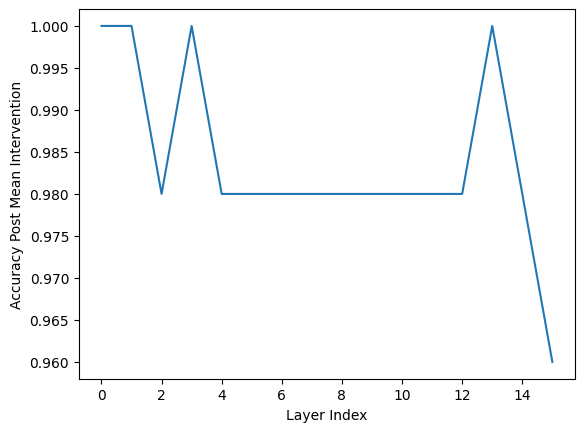

In [45]:
plt.plot(layer_wise_accuracy(named_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()

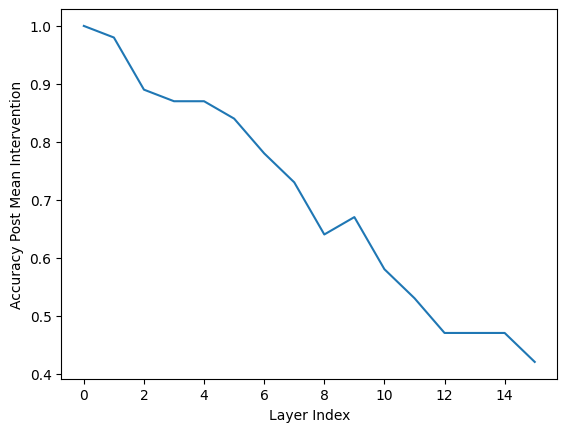

In [46]:
plt.plot(layer_wise_accuracy(country_patching_result_v2))
plt.xlabel("Layer Index")
plt.ylabel("Accuracy Post Mean Intervention")
plt.show()